In [2]:
%load_ext autoreload
%autoreload 2
from confignb import *

INFO:2026-01-25 11:55:54,941:jax._src.xla_bridge:834: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
11:55:54: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [3]:
X, y, pts, ks = h.load_data(DATA_DIR / 'ASCADv_clean.h5')
X_atk, y_atk, pts_atk, ks_atk = h.load_data('data/raw/ASCADv.h5', attack=True)

In [ ]:
rf_pge_means, rf_pge_stds, rf_frs0 = h.eval_model(SEED, pl_baseline, X, y, X_atk, pts_atk, ks_atk, n_repeats=50)

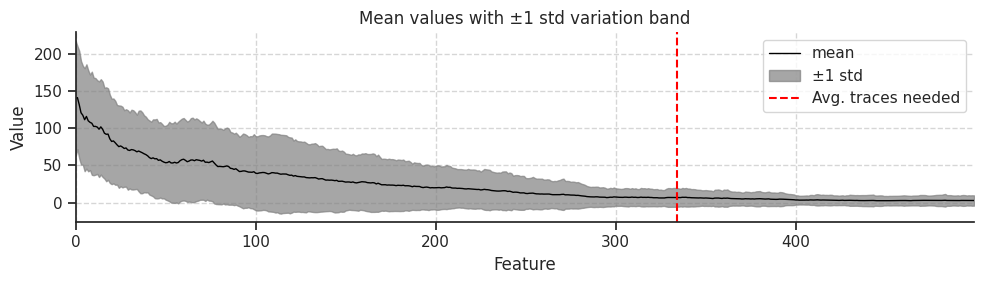

In [18]:
fig, ax = p.plot_pge(rf_pge_means, rf_pge_stds, rf_frs0)
fig.savefig("figures/model_baseline_pge_plot.png")

In [16]:
pl_feat_hw = m.make_pipeline(
    m.RobustScaler(quantile_range=(5, 95)),
    m.SelectFromModel(m.SimpleRFC(max_depth=10), max_features=50),

    m.PolynomialFeatures(degree=(2, 2), interaction_only=True, include_bias=False),
    m.SelectKBest(m.f_classif, k=200),

    # m.SimpleRFC(max_depth=10,),
    m.SelectFromModel(m.SimpleRFC(max_depth=5), max_features=50),
)

11:59:04: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
11:59:04: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
11:59:04: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
11:59:04: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


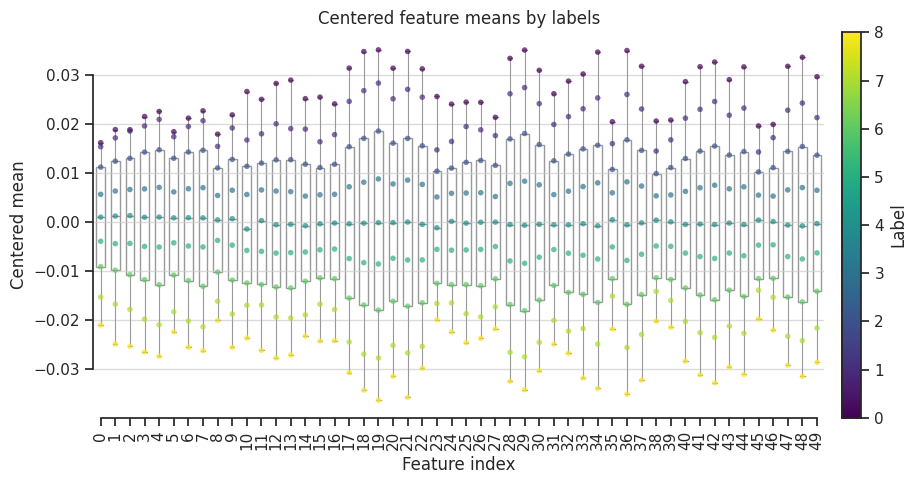

In [ ]:
pl_feat_hw.fit(X, h.hw(y))
X_feat = pl_feat_hw.transform(X)
fig = p.plot_feature_means(pd.DataFrame(X_feat).rename(columns=int), h.hw(y), figsize=(10, 5))

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin


@h.dataclass
class Solver(BaseEstimator):
    extractor: TransformerMixin
    estimator: BaseEstimator
    use_hw = False

    def fit(self, X, y):
        X_feat = self.extractor.fit_transform(X, h.hw(y) if self.use_hw else y)
        self.estimator.fit(X_feat, y)
        return self

    def predict_log_proba(self, X):
        X_feat = self.extractor.transform(X)
        return self.estimator.predict_log_proba(X_feat)


model_hw = Solver(
    extractor=m.make_pipeline(
        m.RobustScaler(quantile_range=(5, 95)),
        m.SelectFromModel(m.SimpleRFC(max_depth=5), max_features=100),

        m.PolynomialFeatures(degree=(2, 2), interaction_only=True, include_bias=False),
        m.SelectKBest(m.f_classif, k=400),

        m.SelectFromModel(m.SimpleRFC(max_depth=5), max_features=100),
    ),
    estimator=m.LogisticRegression(C=0.5, max_iter=500, random_state=SEED)
)

In [ ]:
h.eval_and_plot(SEED, model_hw)

IndexError: invalid index to scalar variable.

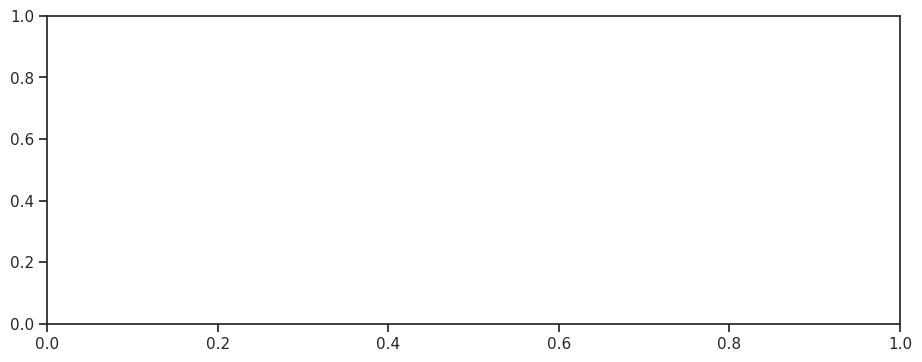

In [ ]:
fig, ax = p.plot_pge(pge_means, frs0, pge_stds)
fig.savefig("figures/model_final_pge_plot.png")

In [ ]:
for prof_idx, atk_idx in h.RSKF2(5, SEED).split(X, y):
    X_prof, y_prof = X.iloc[prof_idx], y.iloc[prof_idx]
    X_atk, pts_atk, ks_atk = X.iloc[atk_idx], pts.iloc[atk_idx], ks.iloc[atk_idx]

    m = pl_final.fit(X_prof, y_prof)

In [ ]:
import onnxruntime as ort

sess = ort.InferenceSession("nn/mlp.onnx")

00:57:01: PGE: 33.982;	 Traces needed 11040.0; 	 PI: 7.93e+00


(np.float64(33.98224), np.float64(11040.0), Array(7.9322977, dtype=float32))